In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#ambil data dari csv
df = pd.read_csv('./Gabungan_IHSG_2010-2020.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df
#df = web.DataReader('^JKSE', data_source='yahoo', start='2010-01-01', end='2018-12-31') 
#df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2533.947998,2576.055908,2532.895996,2575.413086,2575.312988,18339300
2010-01-05,2575.616943,2606.069092,2575.616943,2605.277100,2605.175537,57043800
2010-01-06,2605.480957,2622.115967,2587.709961,2603.297119,2603.195557,51569100
2010-01-07,2603.500977,2611.603027,2570.272949,2586.895020,2586.794189,45510800
2010-01-08,2586.792969,2614.535889,2583.846924,2614.370117,2614.268311,73723500
...,...,...,...,...,...,...
2020-12-22,6146.645996,6174.458984,6010.210938,6023.289063,6023.289063,250085200
2020-12-23,6061.848145,6104.354980,5853.261230,6008.708984,6008.708984,203528500
2020-12-28,6067.000000,6095.007813,5979.904785,6093.554199,6093.554199,180855700


In [3]:
df.shape

(2679, 6)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


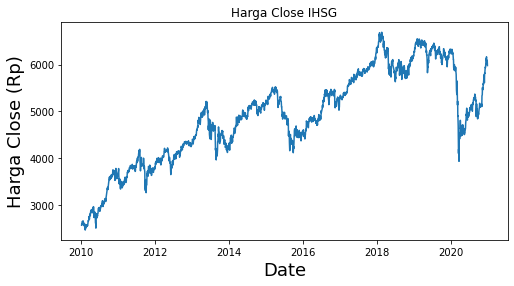

In [4]:
plt.figure(figsize=(8,4))
plt.title('Harga Close IHSG')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Harga Close (Rp)', fontsize=18)
plt.show()

In [5]:
#Ambil data CLOSE saja
data=df.filter(['Open', 'High', 'Low', 'Close', 'Adj Close'])
dataset=data.values
training_data_len=2192 #data dari 2010-2018
#training_data_len=math.ceil(len(dataset)* .8)
data.shape

(2679, 5)

In [6]:
#Scaling Data
scaler=StandardScaler()
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[-2.35827546, -2.34286582, -2.33240983, -2.32133551, -2.32122182],
       [-2.31631172, -2.31262684, -2.28934632, -2.29119657, -2.29108577],
       [-2.28623643, -2.29645925, -2.27715633, -2.29319477, -2.29308389],
       ...,
       [ 1.19977167,  1.20255974,  1.14223954,  1.22919342,  1.22924069],
       [ 1.24581534,  1.25178965,  1.18941511,  1.17128481,  1.17133481],
       [ 1.1847875 ,  1.16322846,  1.12420102,  1.11365855,  1.11371128]])

In [7]:
#bikin scaled training dataset
train_data=scaled_data[0:training_data_len, :]

#split x_train & y_train
x_train = []
y_train = []

train_data.shape

(2192, 5)

In [8]:
n_future = 1
n_past = 10

#isi trainx dan trainy sesuai n nya
for i in range(n_past, len(train_data) - n_future +1): # i = range dari 365 - 3965 (365, 3969-3-1)
    x_train.append(train_data[i - n_past:i, 0:train_data.shape[1]]) #ambil data dari 365 hari yang lalu (0:365, 0:5)
    y_train.append(train_data[i + n_future - 1:i + n_future, 0]) #ambil data buat prediksi (367:368, 0)

In [9]:
#n_past=10
#for i in range(n_past, len(train_data)):
    #x_train.append(train_data[i-n_past:i, 0])
    #y_train.append(train_data[i,0])

In [10]:
#Convert ke Array
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2182, 10, 5)

In [11]:
n_fitur=5 #fitur close 
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],n_fitur))
#x_train.shape

In [12]:
#Building LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, activation='relu',return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 52,595
Trainable params: 52,595
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
2182/2182 [==============================] - 1s 625us/step - loss: 0.1043
Epoch 2/50
2182/2182 [==============================] - 1s 292us/step - loss: 0.0058
Epoch 3/50
2182/2182 [==============================] - 1s 284us/step - loss: 0.0047
Epoch 4/50
2182/2182 [==============================] - 1s 282us/step - loss: 0.0041
Epoch 5/50
2182/2182 [==============================] - 1s 284us/step - loss: 0.0035
Epoch 6/50
2182/2182 [==============================] - 1s 281us/step - loss: 0.0030
Epoch 7/50
2182/2182 [==============================] - 1s 282us/step - loss: 0.0026
Epoch 8/50
2182/2182 [==============================] - 1s 280us/step - loss: 0.0025
Epoch 9/50
2182/2182 [==============================] - 1s 281us/step - loss: 0.0024
Epoch 10/50
2182/2182 [==============================] - 1s 308us/step - loss: 0.0023
Epoch 11/50
2182/2182 [==============================] - 1s 366us/step - loss: 0.0017
Epoch 12/50
2182/2182 [==============================] - 1s 366

In [15]:
#Bikin testing data set
test_data=scaled_data[training_data_len-n_past:, :]
x_test=[]
y_test=dataset[training_data_len:, -1:]
for i in range(n_past, len(test_data)):
    x_test.append(test_data[i-n_past:i,0:5])

In [16]:
#convert data ke numpy array
x_test = np.array(x_test)
# y_test_scaled = scaler.fit_transform(y_test)

In [17]:
#reshape data
# x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_fitur))

In [18]:
#prediksi dari model
predictions=model.predict(x_test)
predictions_copies = np.repeat(predictions, train_data.shape[1], axis=-1)
predictions_inv=scaler.inverse_transform(predictions_copies)[:,0]
predictions_inv.shape

(487,)

In [19]:
# predictions_scaled = scaler.fit_transform(predictions_copies)
# rmse = np.sqrt(np.mean((predictions-y_test_scaled)**2))
# rmse

<ipython-input-20-eda1a21e77b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions_inv


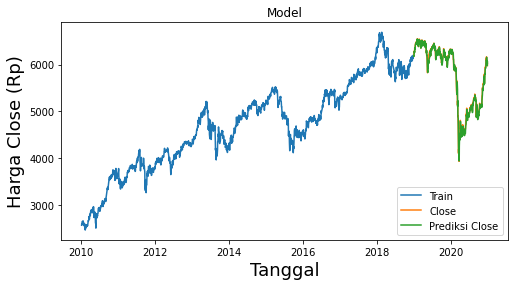

In [20]:
#Plot data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions_inv

#Visualisasi data
plt.figure(figsize=(8,4))
plt.title('Model')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Close (Rp)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Close', 'Prediksi Close'], loc='lower right')
plt.show()

In [21]:
valid[['Close','Predictions']]

,Close,Predictions
Date,,
2019-01-02,6181.174805,6182.698730
2019-01-03,6221.009766,6173.517578
2019-01-04,6274.540039,6212.381836
2019-01-07,6287.224121,6257.509277
2019-01-08,6262.847168,6289.173340
...,...,...
2020-12-22,6023.289063,6155.151367
2020-12-23,6008.708984,6004.316406
2020-12-28,6093.554199,5976.971680


In [22]:
y_test_scaled = scaler.fit_transform(y_test)
predictions_scaled = scaler.fit_transform(predictions_inv)
# rmse = np.sqrt(np.mean((predictions_scaled-y_test_scaled)**2))
predictions_scaled.shape

ValueError: Expected 2D array, got 1D array instead:
array=[6182.6987 6173.5176 6212.382  6257.5093 6289.1733 6253.433  6277.347
 6318.661  6358.108  6323.08   6396.437  6403.2876 6420.6694 6438.712
 6447.6714 6455.409  6450.167  6462.841  6480.267  6448.5044 6435.036
 6460.632  6527.0737 6526.6274 6473.464  6545.2324 6526.4263 6513.3726
 6494.1216 6412.3984 6420.874  6414.986  6382.416  6490.7095 6483.434
 6503.0635 6526.2656 6491.481  6526.1406 6527.8623 6516.0913 6434.1133
 6502.263  6482.455  6427.539  6455.8047 6372.759  6372.2246 6349.213
 6369.0073 6403.901  6450.6465 6498.7456 6471.101  6478.7676 6500.267
 6517.2896 6394.1816 6477.717  6436.452  6475.5137 6456.9067 6449.8804
 6472.11   6490.724  6470.1    6413.751  6479.9834 6467.7856 6404.1367
 6405.891  6433.9614 6470.665  6504.063  6399.64   6462.735  6441.7314
 6362.9824 6388.6704 6413.71   6447.1445 6360.532  6303.5225 6241.7417
 6302.5605 6249.0083 6194.2085 6196.664  6129.4893 6056.5054 5983.9116
 5889.92   5831.2236 5885.0024 5947.813  5923.684  6017.2607 6045.6304
 6081.4062 6022.9526 6093.207  6174.6753 6271.0444 6278.583  6266.5723
 6269.0444 6246.469  6188.722  6252.0723 6330.1064 6323.0063 6302.6855
 6287.614  6324.0557 6308.1323 6349.5366 6355.954  6378.117  6378.9346
 6354.229  6376.434  6370.4883 6343.272  6384.226  6405.604  6410.0396
 6368.44   6422.7803 6394.3916 6391.968  6397.9487 6450.8467 6423.785
 6401.175  6384.991  6401.6216 6315.379  6300.675  6369.5327 6373.896
 6376.6562 6327.493  6165.048  6102.364  6210.595  6254.9155 6274.9746
 6241.035  6205.351  6271.87   6224.422  6283.77   6292.612  6290.2446
 6249.2617 6236.5845 6247.475  6192.4424 6277.3154 6271.9385 6284.689
 6325.435  6283.5527 6260.774  6267.525  6306.6543 6307.0366 6321.89
 6330.03   6371.0527 6339.042  6333.8887 6200.1655 6244.9263 6267.1255
 6238.724  6225.9976 6202.899  6126.851  6139.2046 6222.491  6184.2617
 6163.0894 6136.878  6048.566  6031.8506 6064.197  5987.939  6040.7905
 6019.2314 6020.5635 6093.1973 6115.5894 6142.6685 6159.2344 6172.1187
 6186.06   6194.7725 6213.124  6243.591  6323.8916 6238.111  6266.4175
 6275.8506 6292.492  6218.653  6208.83   6183.32   6255.85   6205.0176
 6152.945  6174.541  6140.747  6174.784  6135.035  6086.5464 6127.555
 6111.609  6145.94   6142.943  6106.257  6096.717  6062.5986 6025.025
 6017.864  5943.175  6002.919  6108.9854 6116.6357 6099.4023 6148.6226
 6172.427  6186.8296 6176.8887 6176.8887 6135.7144 6199.2275 6205.074
 6236.2544 6291.134  6236.54   6278.2373 6300.48   6316.1733 6325.964
 6295.3936 6281.6924 6320.9565 6248.04   6279.4307 6217.3726 6275.4863
 6270.5693 6290.3    6319.4565 6271.9126 6282.062  6288.8525 6242.8975
 6238.793  6233.137  6246.6084 6240.9233 6122.6445 6118.0273 6115.002
 6047.9126 5934.1436 5883.0396 5931.0273 5965.0054 5979.9463 5990.259
 5938.025  5952.3027 5899.1475 5864.248  5856.881  5858.9946 5874.8105
 5918.49   5931.066  5866.573  5791.896  5775.779  5675.623  5521.681
 5402.563  5367.3784 5520.848  5620.5938 5624.537  5475.16   5111.2
 5231.37   5134.9736 4883.742  4860.9033 4693.15   4468.95   4345.8457
 4126.971  4152.715  3997.1729 3946.044  4253.769  4505.859  4389.802
 4522.681  4460.128  4511.731  4624.1064 4788.5034 4765.565  4597.15
 4625.858  4605.926  4685.493  4609.171  4454.4927 4611.576  4564.9053
 4482.8755 4535.163  4583.255  4477.6494 4497.5547 4513.2383 4550.7744
 4685.2837 4580.0835 4618.035  4591.6216 4582.872  4622.965  4564.745
 4533.814  4496.6113 4486.3154 4497.369  4536.5034 4530.0645 4604.7974
 4621.368  4694.537  4733.3906 4823.552  4915.693  4898.58   4912.966
 5044.4    5018.122  4893.282  4834.414  4834.273  4809.1553 4952.6294
 4978.451  4914.104  4934.57   4905.318  4869.01   4943.627  4880.454
 4893.849  4883.605  4897.041  4899.6143 4950.8755 4963.9526 4977.497
 4976.8765 5053.086  5040.6284 5018.9863 5050.1694 5065.7334 5067.1997
 5086.762  5069.422  5038.167  5096.8037 5099.9517 5131.498  5070.4766
 5103.875  5101.546  5129.714  5126.0435 4976.762  5060.7466 5104.4604
 5161.423  5127.982  5152.055  5174.365  5212.6797 5225.8584 5232.719
 5277.092  5262.4473 5265.6665 5318.0605 5326.682  5352.3086 5332.7725
 5229.6846 5287.3257 5298.995  5262.5317 5221.028  5216.123  5235.156
 5131.943  4876.2827 4962.951  5145.435  5085.659  5052.614  5028.3364
 5046.214  4987.1343 4920.073  4905.129  4826.324  4928.3564 4899.4263
 4868.524  4857.5005 4955.353  4902.8496 4945.7524 4994.723  4981.674
 5026.528  5038.7324 5085.2847 5107.8105 5159.208  5091.7114 5087.722
 5111.8975 5085.359  5087.779  5075.6685 5103.504  5129.49   5114.4673
 5095.9526 5149.6587 5094.2173 5240.9697 5305.656  5340.3335 5448.09
 5489.7944 5445.33   5446.4375 5481.8667 5516.744  5540.4717 5571.952
 5561.559  5631.318  5683.926  5666.7417 5729.9297 5764.058  5587.661
 5699.3784 5781.986  5802.8574 5790.0947 5910.353  5920.581  5919.496
 5926.8516 5991.042  5987.5127 6092.5786 6091.0347 6093.0684 6155.1514
 6004.3164 5976.9717 6076.152  6022.125 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions_scaled.shape
mean_absolute_error(y_test_scaled, predictions_scaled)

In [ ]:
%store rmse
%store predictions